<a href="https://colab.research.google.com/github/marquesbmc/Artificial-Intelligence/blob/main/grid2d_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grid2D - Ambiente de Aprendizado por Reforço

## Visão Geral

O ambiente **Grid2D** é um ambiente de aprendizado por reforço inspirado no Grid World environment do livro de Reinforcement Learning de Sutton, capítulo 4. Projetado para testar e desenvolver algoritmos de aprendizado de máquina em tarefas de navegação em um ambiente 2D. Neste ambiente, um agente (anteriormente chamado de "agente") deve navegar por um grid 2D, evitar obstáculos e alcançar metas para maximizar sua recompensa total. O ambiente oferece suporte tanto à visão completa do ambiente quanto à visão parcial do agente.

## Regras do Cenário

As regras do cenário são as seguintes:

- O ambiente é representado como um grid 2D, onde o agente e outros elementos estão localizados.

- O agente (anteriormente chamado de "Agent") é representado por um quadrado azul.

- Existem três tipos de elementos no ambiente:
  1. **Objetivos (Goals)**: Representados por quadrados verdes. O agente deve alcançar os objetivos para receber uma recompensa positiva.
  2. **Fogo (Fire)**: Representado por quadrados vermelhos. Se o agente colidir com o fogo, ele receberá uma penalidade.
  3. **Espaço vazio (Empty Space)**: Áreas vazias representadas por espaços pretos no grid.

- O agente pode tomar quatro ações discretas:
  1. Mover para cima (0)
  2. Mover para baixo (1)
  3. Mover para a esquerda (2)
  4. Mover para a direita (3)

- O objetivo do agente é maximizar sua recompensa total, que é determinada pelas seguintes regras:
  - O agente recebe uma recompensa positiva quando alcança um objetivo (Goal).
  - O agente recebe uma penalidade quando colide com o fogo (Fire).
  - O agente recebe uma penalidade adicional se tentar sair dos limites do grid (bordas).

- O episódio termina quando o agente alcança um objetivo (recebe uma recompensa positiva) ou colide com o fogo (recebe uma penalidade).

## Uso do Ambiente

Para usar o ambiente Grid2D, siga estas etapas:

1. Importe o ambiente e crie uma instância:
   ```python
   from grid2d_env import Grid2DEnv

   env = Grid2DEnv(sizeX=10, sizeY=10)  # Substitua os tamanhos X e Y conforme necessário

2. Comece um episódio chamando o método reset():

   ```python
   state = env.reset()

3. No loop principal do seu algoritmo de aprendizado, escolha ações e execute-as chamando o método step(action):

   ```python
   action = env.action_space.sample()  # Substitua esta ação pela escolha do seu agente
   next_state, reward, done, _ = env.step(action)

4. Você pode renderizar a visão parcial do agente para fins de visualização:

    ```python
    partial_view = env.render(type='parcial', mode='human')

5. Continue o loop até que o episódio termine (quando done é True). O total da recompensa acumulada pode ser acessado durante ou após o episódio.

6. Ao final do episódio, você pode chamar env.close() para encerrar o ambiente.

## Personalização
Você pode personalizar o ambiente ajustando os tamanhos do grid, o número de objetivos e a disposição dos elementos no ambiente.

## Notas Adicionais
Este ambiente Grid2D pode ser útil para experimentar com algoritmos de aprendizado por reforço em cenários de navegação 2D. Sinta-se à vontade para adaptar e estender o ambiente para suas próprias necessidades e desafios de pesquisa em aprendizado de máquina.

In [ ]:
!pip install gym

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


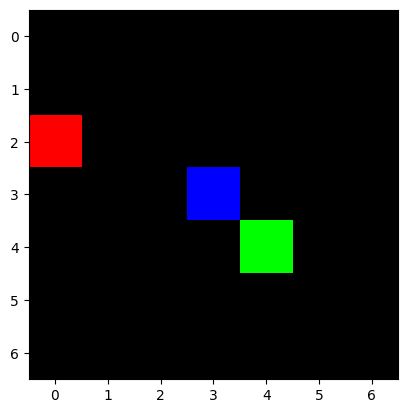

In [10]:
import numpy as np
import itertools
from skimage.transform import resize
import matplotlib.pyplot as plt
import gym
from gym import spaces

class Grid2DObject(object):
    def __init__(self, coordinates, size, intensity, channel, reward, name):
        self.x = coordinates[0]
        self.y = coordinates[1]
        self.size = size
        self.intensity = intensity
        self.channel = channel
        self.reward = reward
        self.name = name

class Grid2DEnv(gym.Env):
    def __init__(self, sizeX, sizeY):
        super(Grid2DEnv, self).__init__()

        self.sizeX = sizeX  # Defina o tamanho X do grid
        self.sizeY = sizeY  # Defina o tamanho Y do grid

        # Define action and observation space
        self.action_space = spaces.Discrete(4)  # 4 possible actions
        self.observation_space = spaces.Box(low=0, high=255, shape=(84, 84, 3), dtype=np.uint8)

        self.reset()

    def _newPosition(self, occupied_positions):
        # Retorna uma nova posição que não está ocupada.
        iterables = [range(self.sizeX), range(self.sizeY)]
        points = []
        for t in itertools.product(*iterables):
            points.append(t)
        for pos in occupied_positions:
            if pos in points:
                points.remove(pos)
        location = np.random.choice(range(len(points)), replace=False)
        return points[location]

    def reset(self):
        self.objects = []
        occupied_positions = []

        # Adicionando o agente
        agent_pos = self._newPosition(occupied_positions)
        agent = Grid2DObject(agent_pos, 1, 1, 2, None, 'agent')
        self.objects.append(agent)
        occupied_positions.append(agent_pos)

        # Adicionando 1 ou 2 "goal" aleatoriamente
        num_goals = np.random.choice([1, 2])
        for _ in range(num_goals):
            goal_pos = self._newPosition(occupied_positions)
            goal_obj = Grid2DObject(goal_pos, 1, 1, 1, 1, 'goal')
            self.objects.append(goal_obj)
            occupied_positions.append(goal_pos)

        # Adicionando 3 "fire"
        for _ in range(3):
            fire_pos = self._newPosition(occupied_positions)
            fire_obj = Grid2DObject(fire_pos, 1, 1, 0, -1, 'fire')
            self.objects.append(fire_obj)
            occupied_positions.append(fire_pos)

        state = self.renderEnv()
        return state

    def step(self, action):
        penalty = self.moveChar(action)
        reward, done = self.checkGoal()
        state = self.renderEnv()
        return state, (reward + penalty), done, {}

    def render(self, mode='human', type='total'):
        if type == 'total':
            state = self.renderEnv()
            if mode == 'human':
                plt.imshow(state, interpolation="nearest")
                plt.show()
            elif mode == 'rgb_array':
                return state
        elif type == 'parcial':
            state = self.renderEnvParcial()
            if mode == 'human':
                plt.imshow(state, interpolation="nearest")
                plt.show()
            elif mode == 'rgb_array':
                return state

    def close(self):
        pass

    def moveChar(self, direction):
        # Move o personagem com base na direção fornecida.
        # 0 - cima, 1 - baixo, 2 - esquerda, 3 - direita
        agent = self.objects[0]
        agentX = agent.x
        agentY = agent.y
        penalize = 0.0

        # Calcula a próxima posição com base na direção
        nextX, nextY = agent.x, agent.y
        if direction == 0 and agent.y >= 1:
            nextY -= 1
        elif direction == 1 and agent.y <= self.sizeY - 2:
            nextY += 1
        elif direction == 2 and agent.x >= 1:
            nextX -= 1
        elif direction == 3 and agent.x <= self.sizeX - 2:
            nextX += 1

        # Verifica se a próxima posição está fora do grid (fora das bordas)
        if nextX < 0 or nextX >= self.sizeX or nextY < 0 or nextY >= self.sizeY:
            penalize = -0.1  # Penalidade por tentar pular a borda

        # Verifica se a próxima posição está ocupada por um "fire"
        elif any(obj.name == 'fire' and obj.x == nextX and obj.y == nextY for obj in self.objects):
            penalize = -0.1  # Penalidade por tentar entrar em uma posição ocupada por "fire"
        else:
            agent.x, agent.y = nextX, nextY

        return penalize

    def checkGoal(self):
        # Verifica se o agente atingiu algum objetivo.
        agent = [obj for obj in self.objects if obj.name == 'agent'][0]
        goals = [obj for obj in self.objects if obj.name == 'goal']

        for goal in goals:
            # Verifica se o agente está a uma distância de 1 unidade do "goal"
            if abs(agent.x - goal.x) <= 1 and abs(agent.y - goal.y) <= 1:
                return 1.0, True  # Recompensa 1 e episódio termina

        # Se o agente estiver na mesma posição que o "fire", ele recebe uma penalidade
        fires = [obj for obj in self.objects if obj.name == 'fire']
        for fire in fires:
            if agent.x == fire.x and agent.y == fire.y:
                agent.x, agent.y = agentX, agentY  # Retorna o agente para a posição anterior
                return -1.0, True  # Penalidade -1 e episódio termina

        return 0.0, False  # Sem recompensa e o episódio continua

    def renderEnv(self):
        # Renderiza o ambiente de jogo como uma imagem retangular.
        a = np.ones([self.sizeY, self.sizeX, 3])
        a[:, :, :] = 0  # Preenche o fundo com a cor preta

        for item in self.objects:
            a[item.y:item.y + item.size, item.x:item.x + item.size, item.channel] = item.intensity

        return a

    def renderEnvParcial_3(self):
        # Renderiza a visão parcial do agente como uma imagem retangular.
        agent = [obj for obj in self.objects if obj.name == 'agent'][0]
        x, y = agent.x, agent.y

        # Defina o tamanho da visão parcial (ajuste conforme necessário)
        partial_size = 7
        half_partial_size = partial_size // 2

        partial_view = np.zeros([partial_size, partial_size, 3], dtype=np.uint8)

        for i in range(partial_size):
            for j in range(partial_size):
                pos_x = x - half_partial_size + i
                pos_y = y - half_partial_size + j

                if 0 <= pos_x < self.sizeX and 0 <= pos_y < self.sizeY:
                    obj_in_position = next((obj for obj in self.objects if obj.x == pos_x and obj.y == pos_y), None)

                    if obj_in_position:
                        if obj_in_position.name == 'agent':
                            partial_view[j, i, :] = [0, 0, 255]  # Cor azul para o agente
                        elif obj_in_position.name == 'goal':
                            partial_view[j, i, :] = [0, 255, 0]  # Cor verde para o objetivo (goal)
                        elif obj_in_position.name == 'fire':
                            partial_view[j, i, :] = [255, 0, 0]  # Cor vermelha para o fogo (fire)
                    else:
                        # Define a cor do grid como preto
                        partial_view[j, i, :] = [0, 0, 0]  # Cor preta para o grid
                else:
                    # Preenche os campos fora do grid com a cor branca
                    partial_view[j, i, :] = [255, 255, 255]  # Cor branca

        return partial_view

    def renderEnvParcial(self):
        # Renderiza a visão parcial do agente como uma imagem retangular.
        agent = [obj for obj in self.objects if obj.name == 'agent'][0]
        x, y = agent.x, agent.y

        # Defina o tamanho da visão parcial (ajuste conforme necessário)
        partial_size = 7
        half_partial_size = partial_size // 2

        partial_view = np.zeros([partial_size, partial_size, 3], dtype=np.uint8)

        for j in range(partial_size):  # Loop nas linhas (eixo y) primeiro
            for i in range(partial_size):  # Loop nas colunas (eixo x) em segundo lugar
                pos_x = x - half_partial_size + i
                pos_y = y - half_partial_size + j

                if 0 <= pos_x < self.sizeX and 0 <= pos_y < self.sizeY:
                    obj_in_position = next((obj for obj in self.objects if obj.x == pos_x and obj.y == pos_y), None)

                    if obj_in_position:
                        if obj_in_position.name == 'agent':
                            partial_view[j, i, :] = [0, 0, 255]  # Cor azul para o agente
                        elif obj_in_position.name == 'goal':
                            partial_view[j, i, :] = [0, 255, 0]  # Cor verde para o objetivo (goal)
                        elif obj_in_position.name == 'fire':
                            partial_view[j, i, :] = [255, 0, 0]  # Cor vermelha para o fogo (fire)
                    else:
                        # Define a cor do grid como preto
                        partial_view[j, i, :] = [0, 0, 0]  # Cor preta para o grid
                else:
                    # Preenche os campos fora do grid com a cor branca
                    partial_view[j, i, :] = [255, 255, 255]  # Cor branca

        return partial_view


# Exemplo de uso:
env = Grid2DEnv(sizeX=10, sizeY=10)
observation = env.reset()
env.render(mode='human', type='parcial')


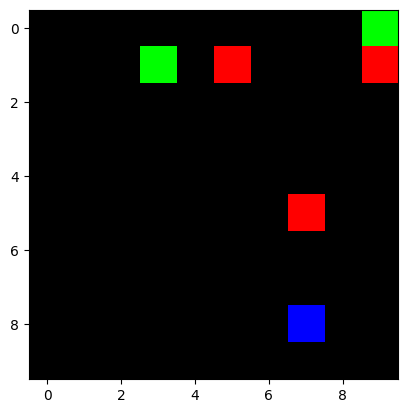

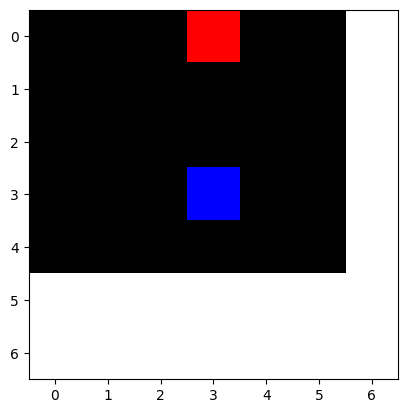

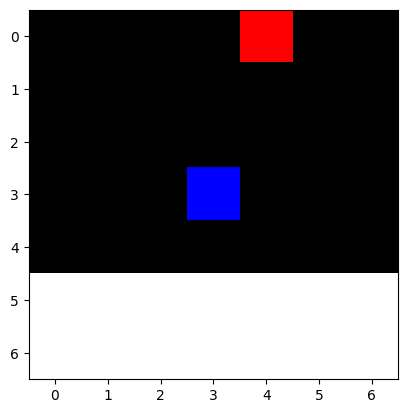

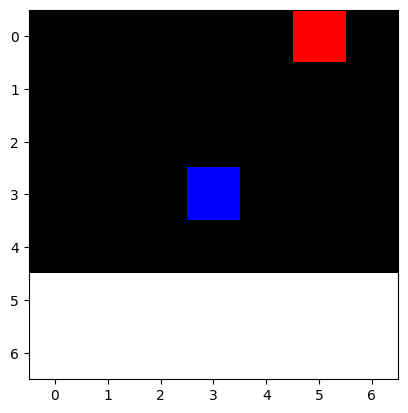

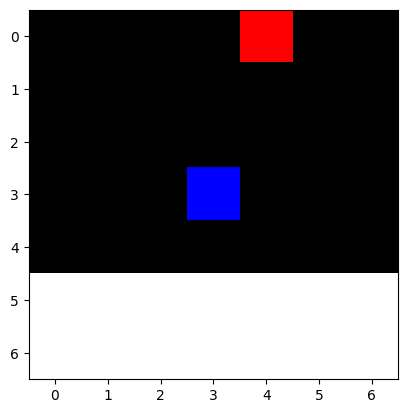

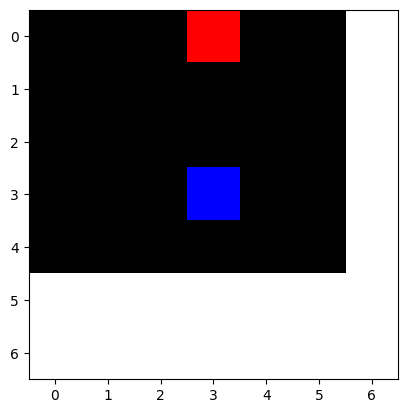

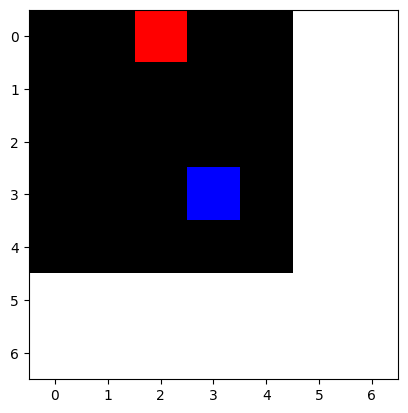

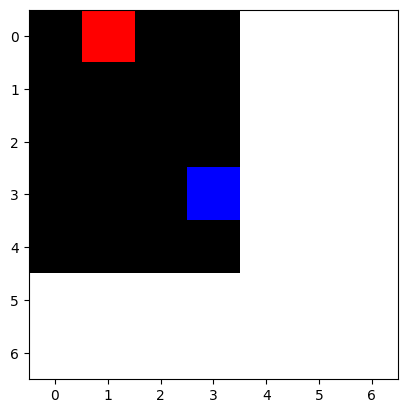

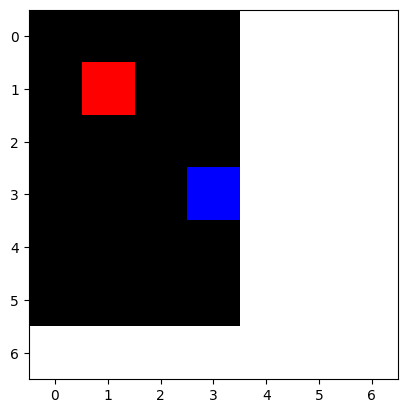

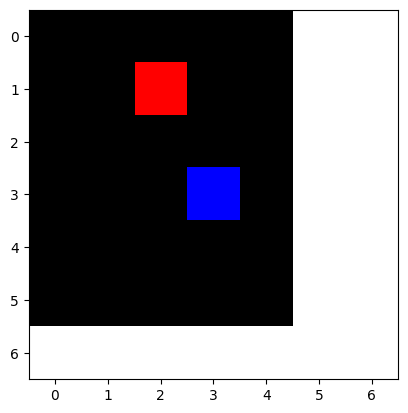

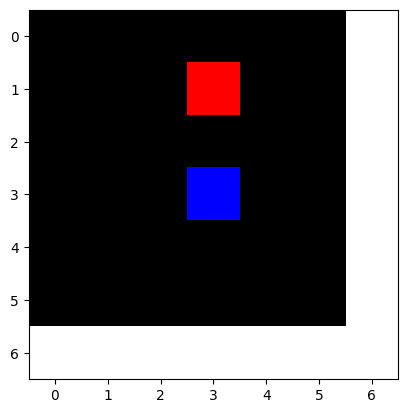

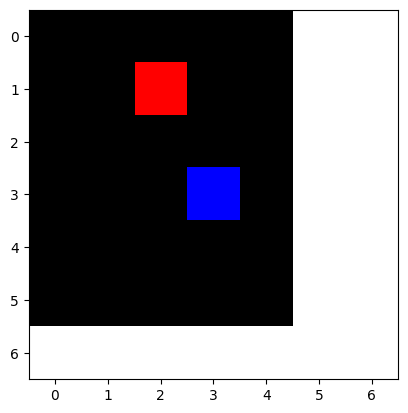

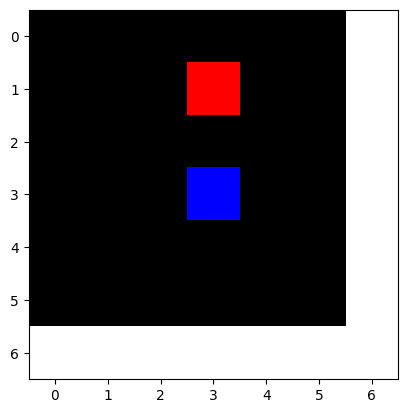

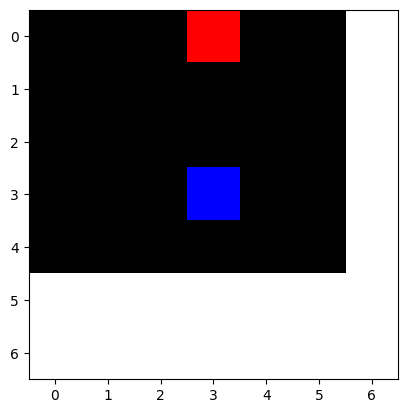

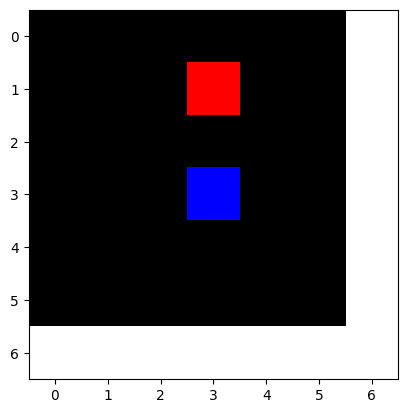

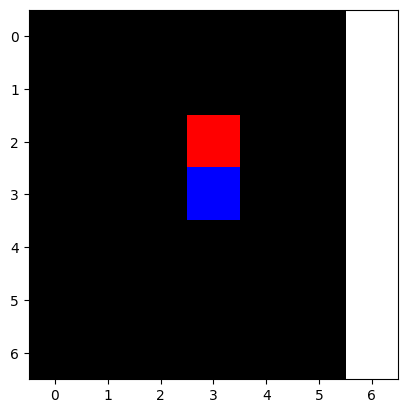

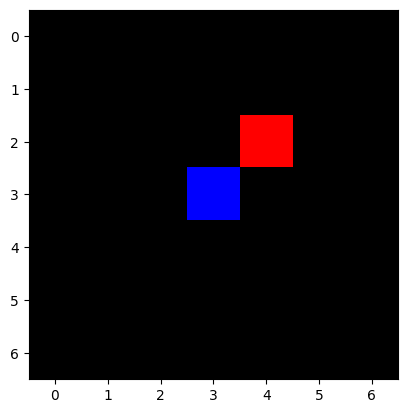

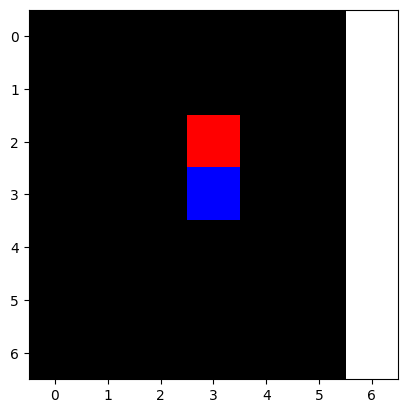

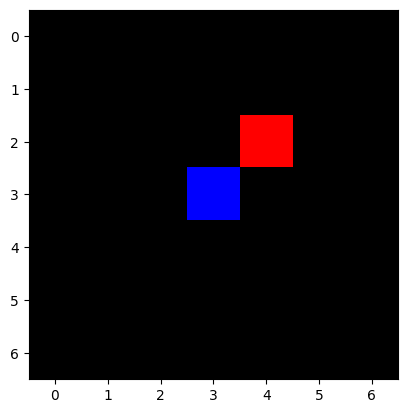

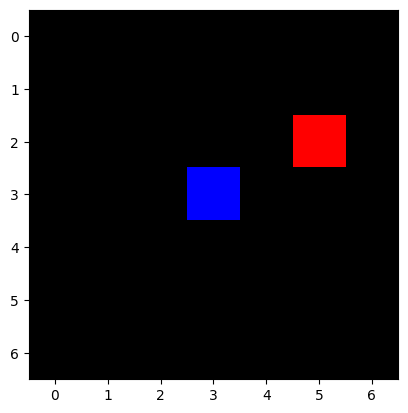

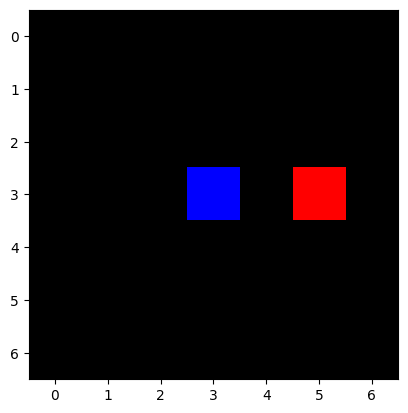

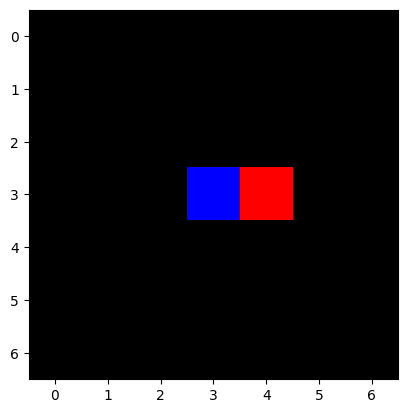

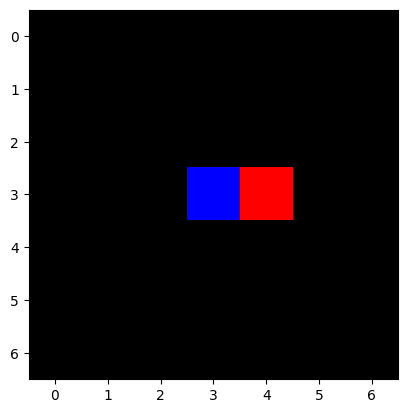

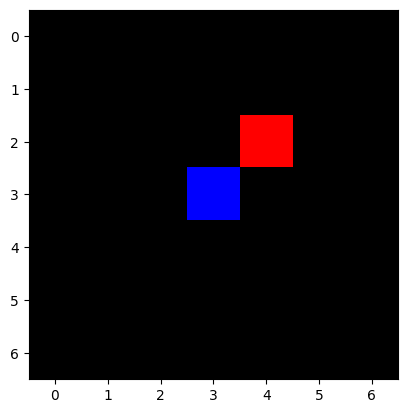

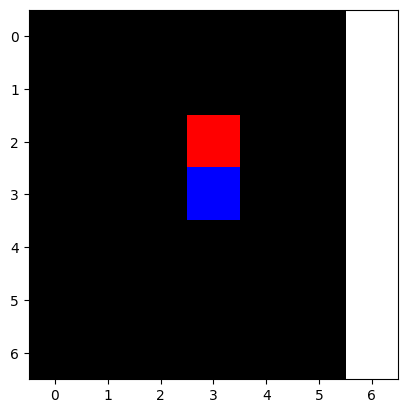

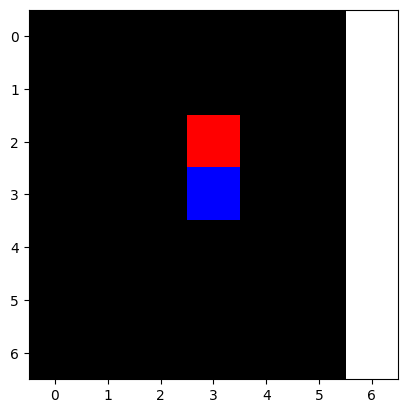

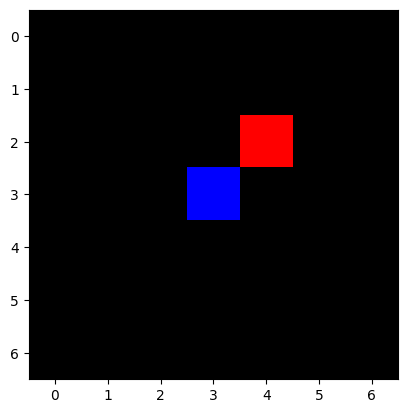

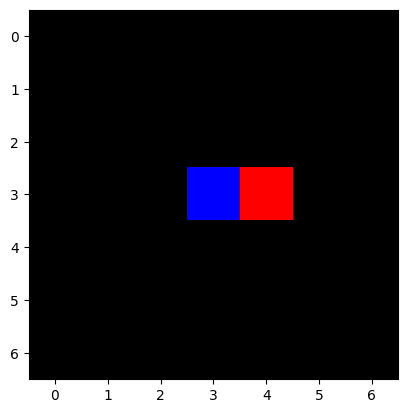

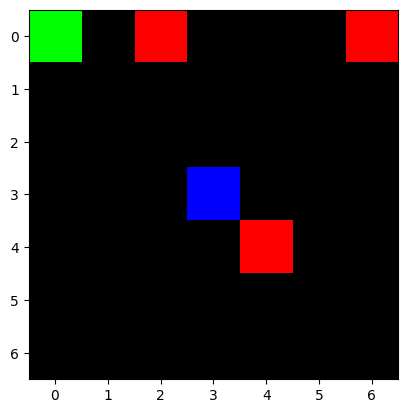

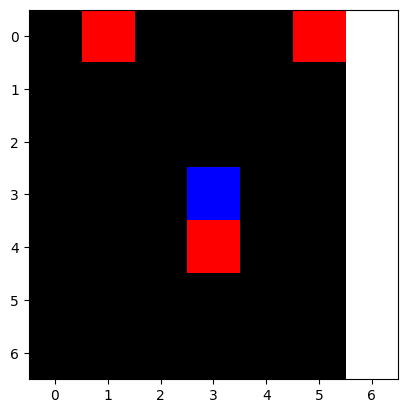

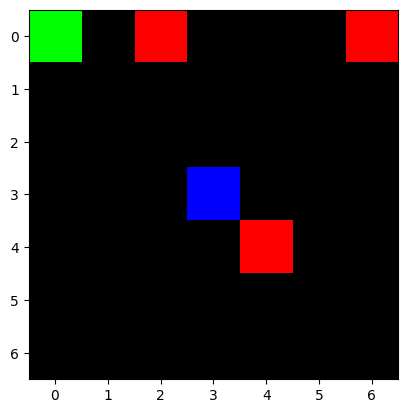

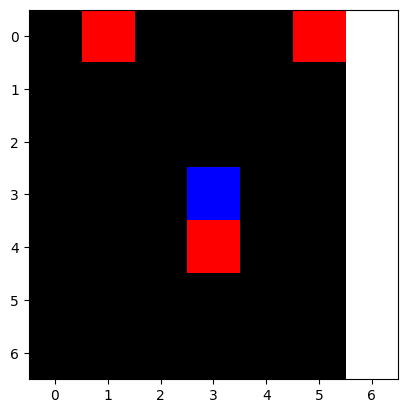

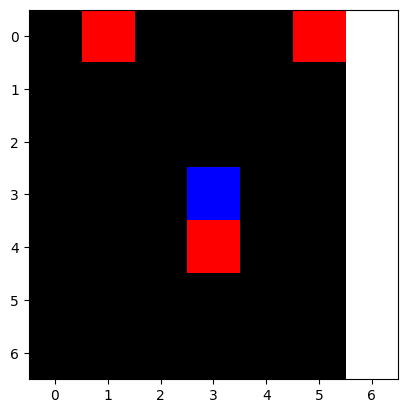

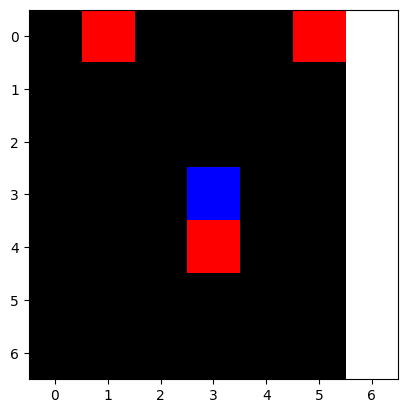

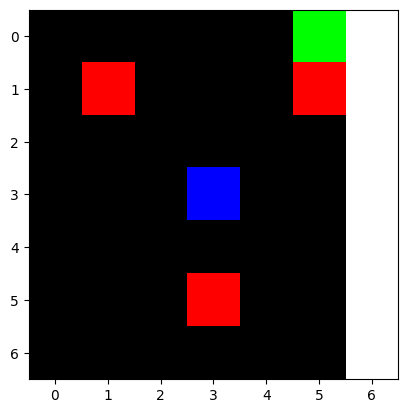

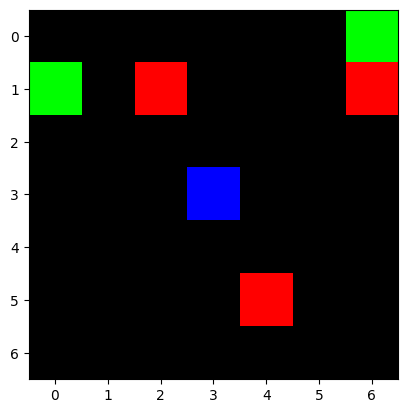

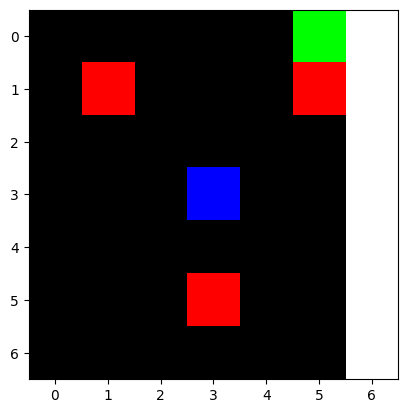

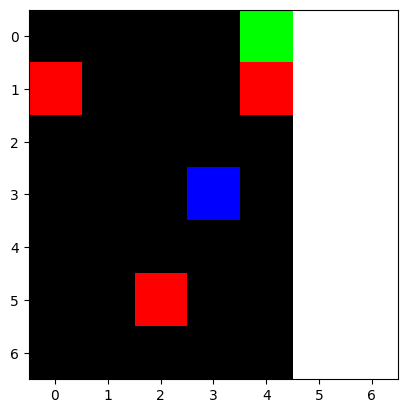

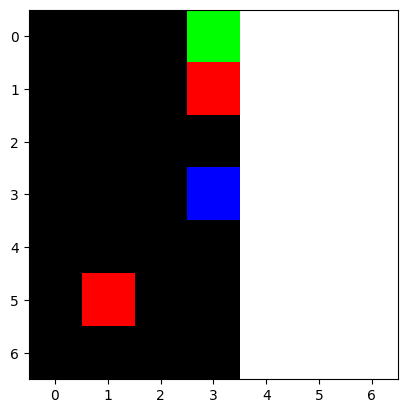

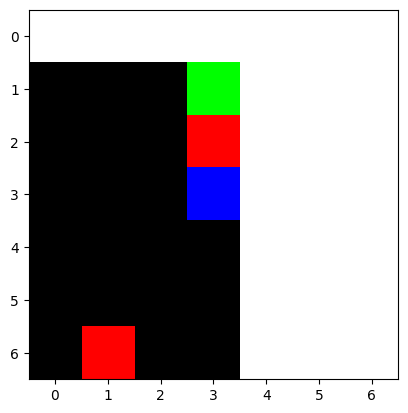

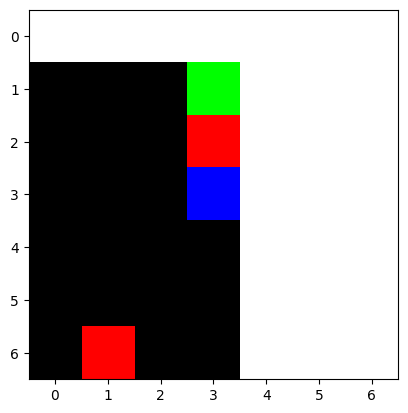

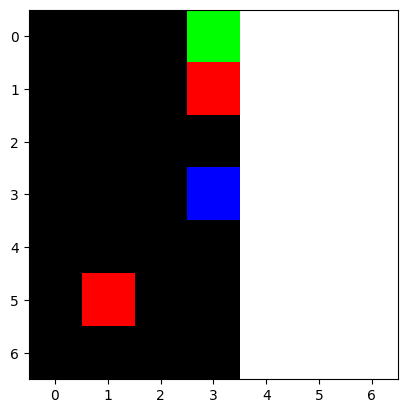

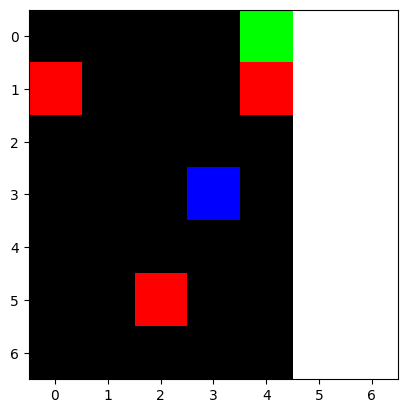

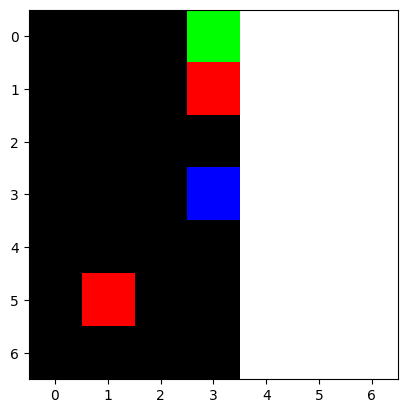

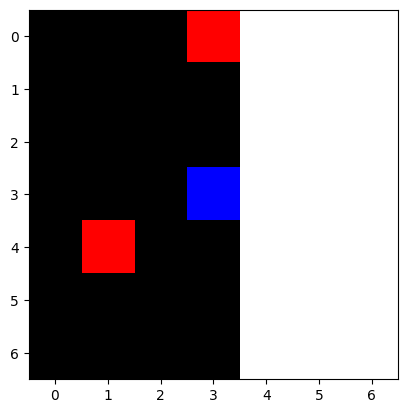

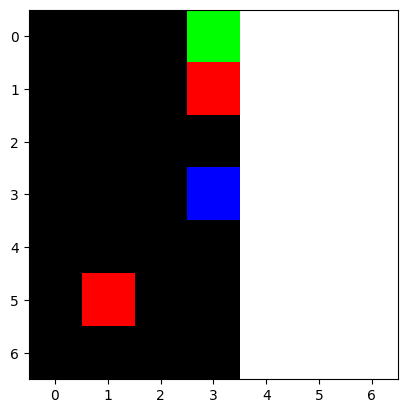

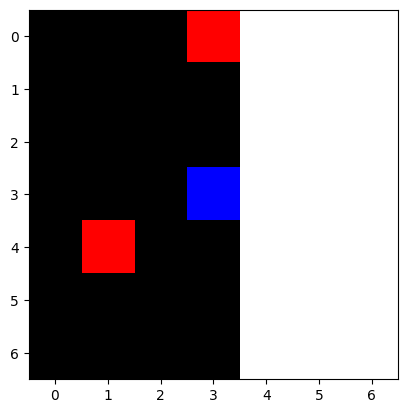

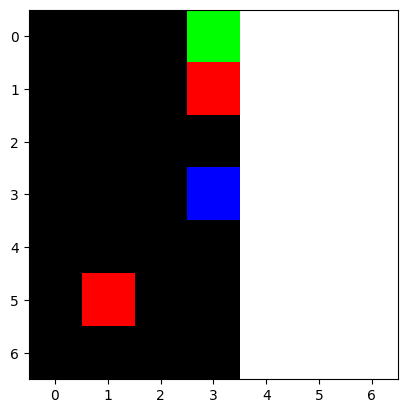

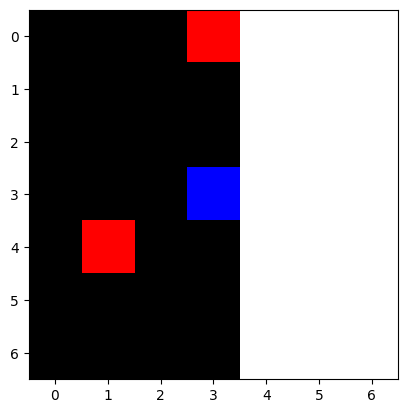

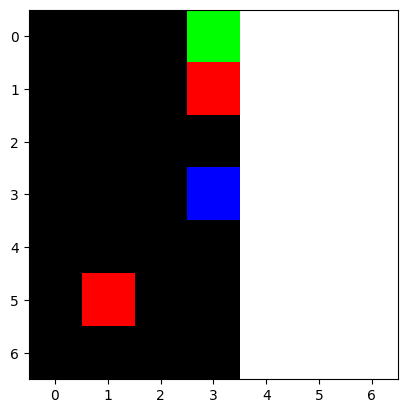

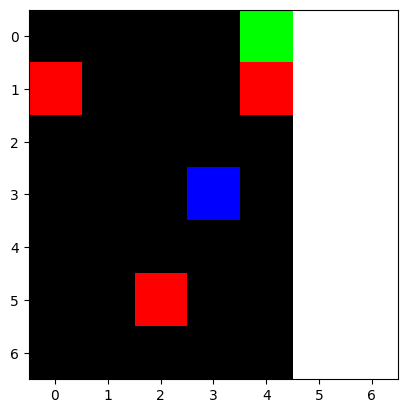

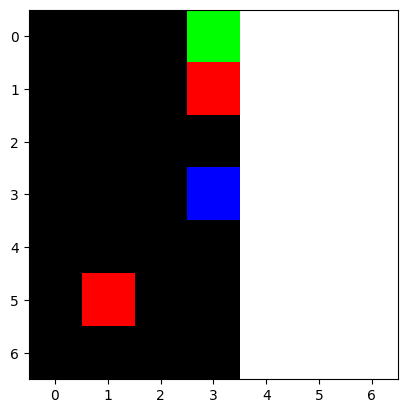

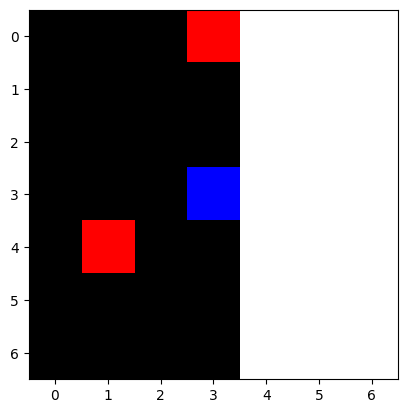

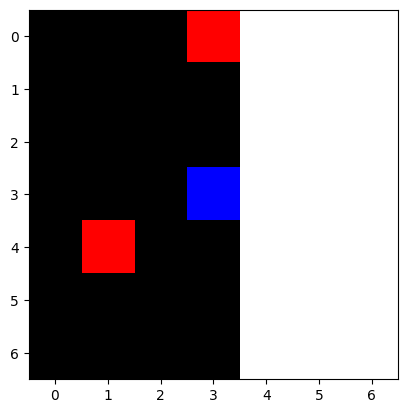

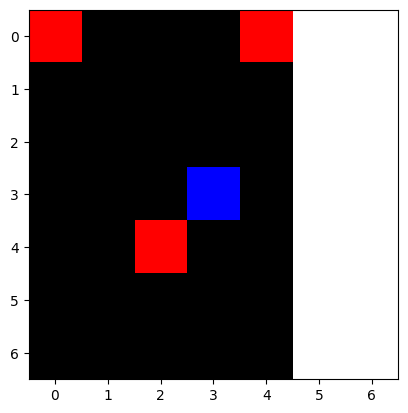

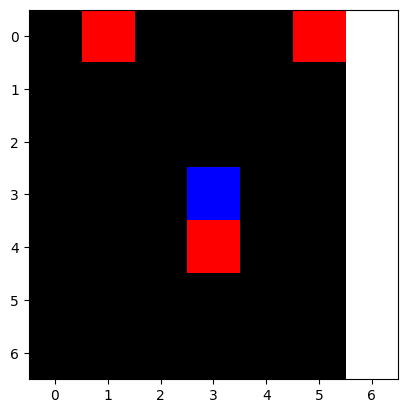

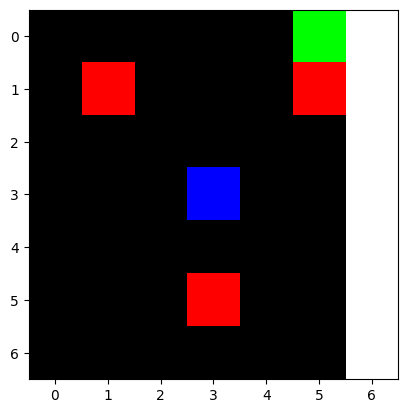

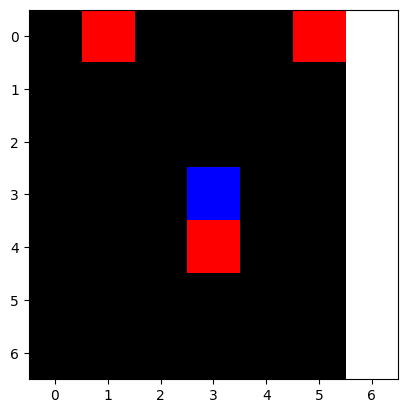

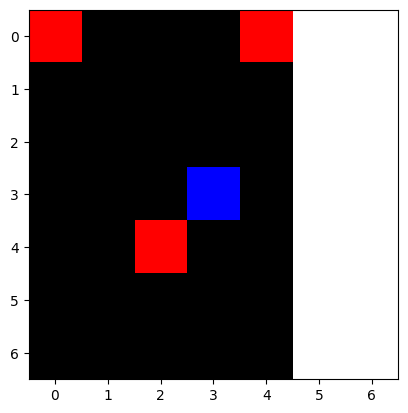

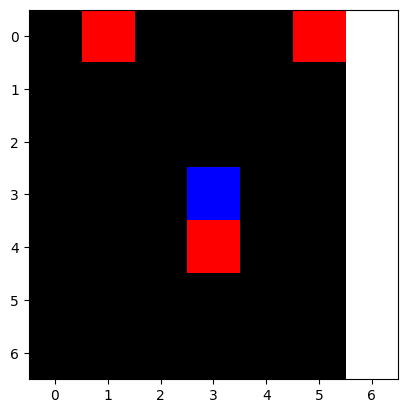

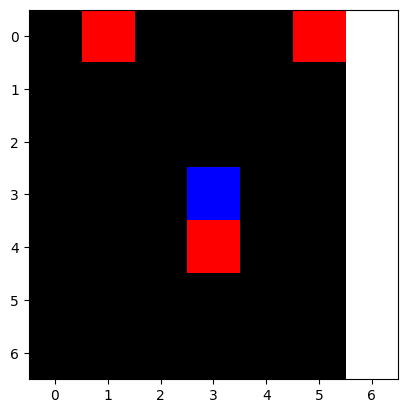

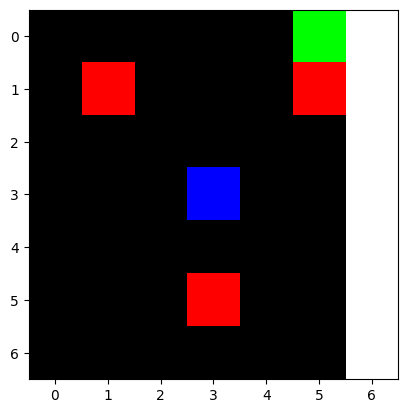

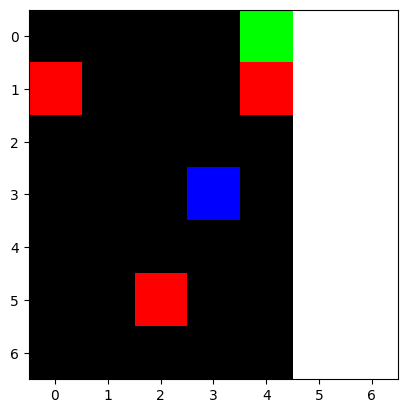

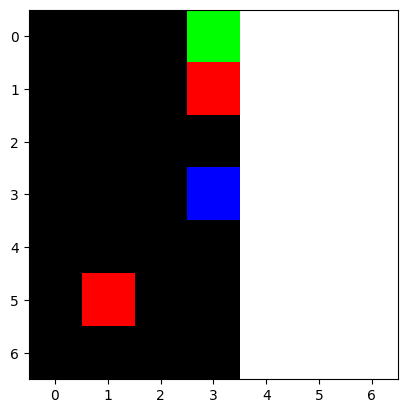

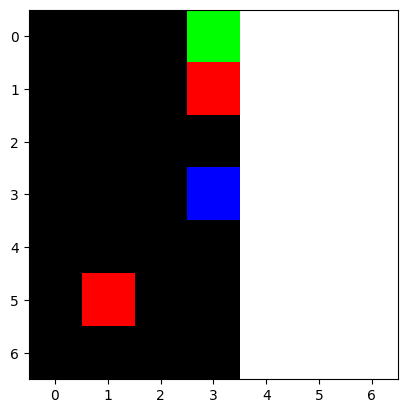

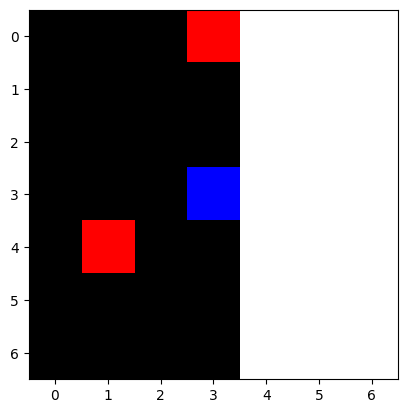

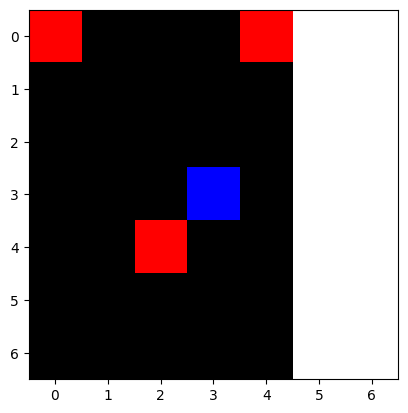

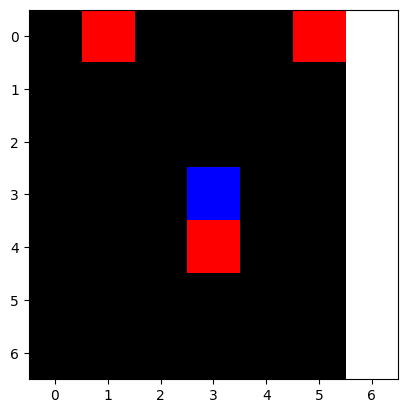

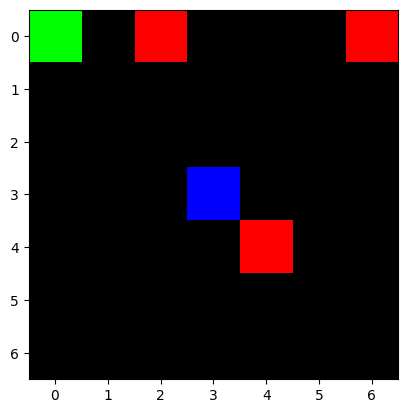

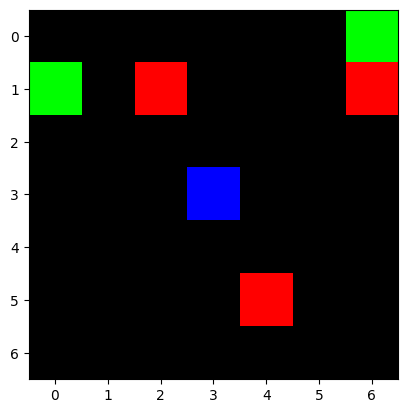

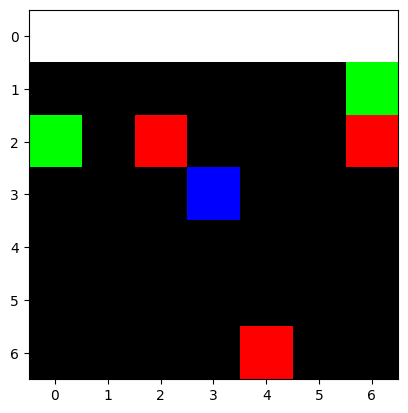

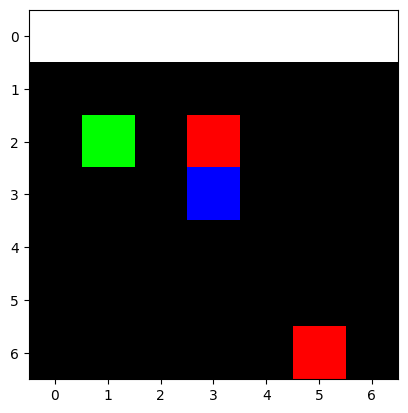

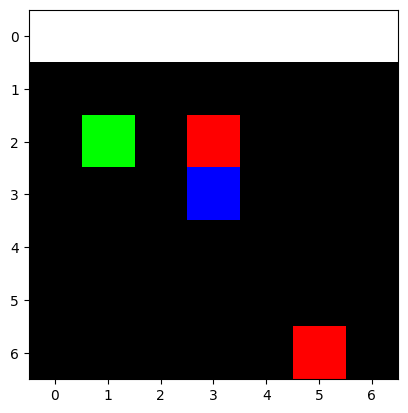

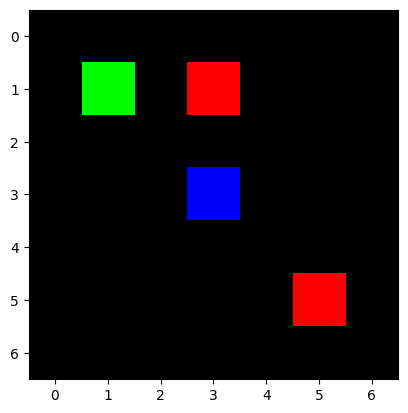

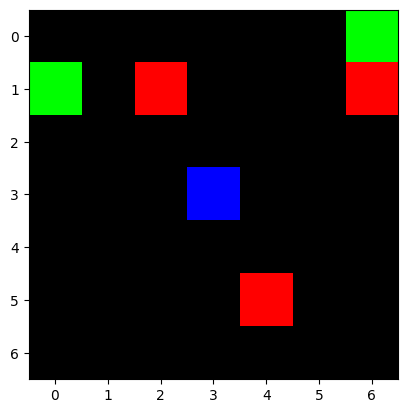

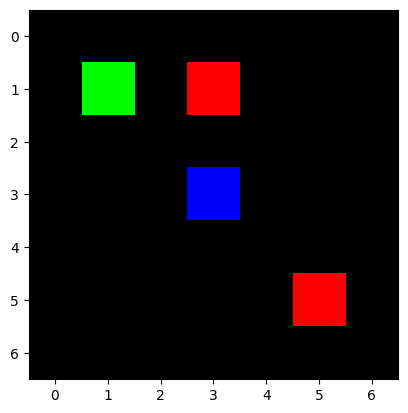

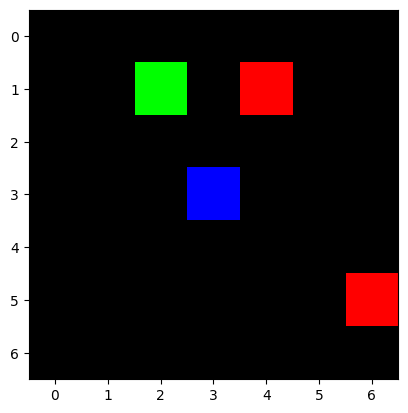

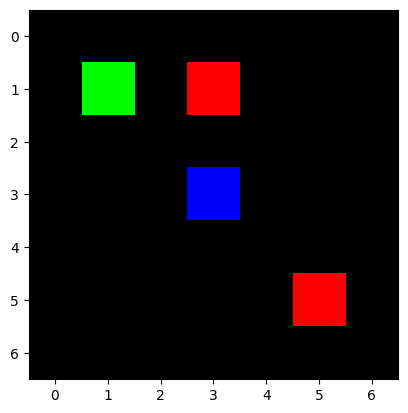

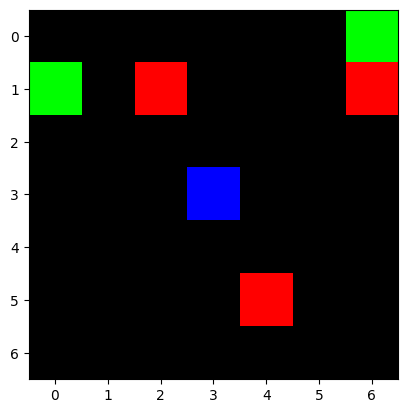

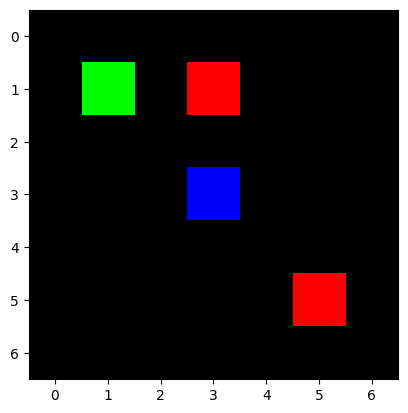

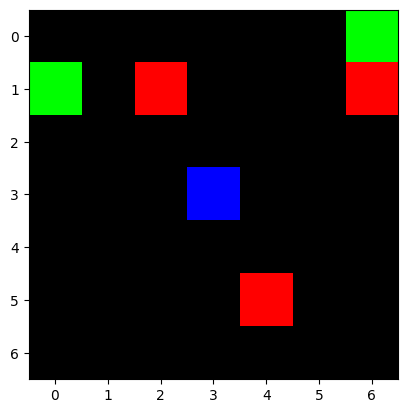

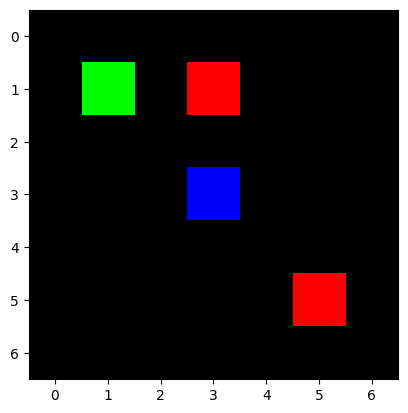

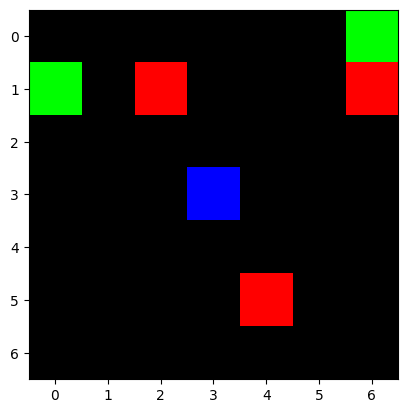

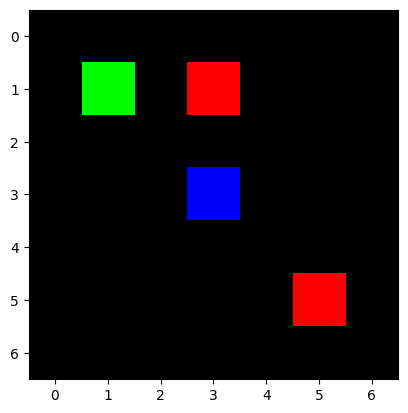

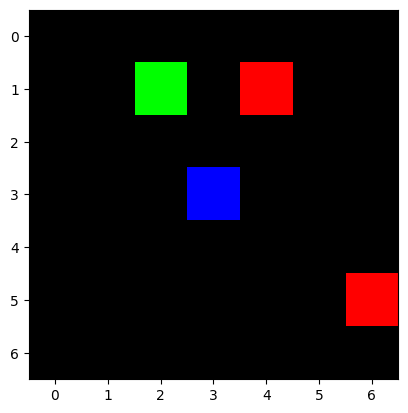

Episode 1 finished with total reward: 0.4


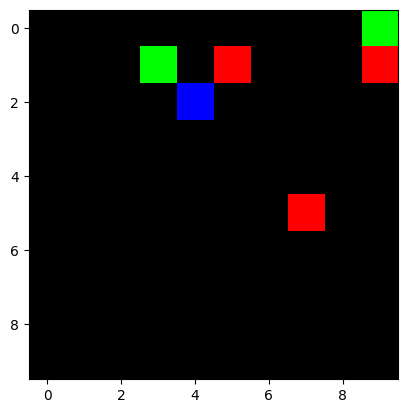

In [18]:
if __name__ == "__main__":
    # Crie uma instância do ambiente
    env = Grid2DEnv(sizeX=10, sizeY=10)  # Defina partial=True para visão parcial

    # Número de episódios para testar
    num_episodes = 1


    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        envTotal = env.render()
        while not done:
            # Renderize a visão parcial do agente
            partial_view = env.render(type='parcial')

            # Escolha uma ação aleatória
            action = env.action_space.sample()

            # Execute a ação no ambiente
            next_state, reward, done, _ = env.step(action)

            total_reward += reward

        print(f"Episode {episode + 1} finished with total reward: {total_reward}")

    envTotal = env.render()
    env.close()
